## 0. Carga de librerías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from math import log
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.collections import LineCollection
import antropy as ant

# 1. Modelo determinista
Vamos a implementar Lotka-Volterra para $N=4$ especies. Usaremos la expresión
$$
\frac{dx_i}{dt} = r_ix_i\left( 1- \sum_{j=1}^N a_{ij}x_j \right)
$$

In [2]:
# generamos las funciones para cada especie

def system(t,x,r,a):
    '''
    :param x: vector de longitud N
    :param r: vector de tasa de crecimiento (r_i)
    :param a: matriz (N,N) con los coeficientes a_ij
    :return: numpy array
    '''
    N = len(x)
    dxdt = np.zeros(N)
    for i in range(N):
        interaction = np.sum(a[i,:]*x)
        dxdt[i] = r[i] * x[i] * (1 - interaction)
    return dxdt

## 1.1. Evolución temporal

In [3]:
# resolvemos con integración

N=4
r = np.array(
    [1, 0.72, 1.53, 1.27]
)

a = np.array([
    [1, 1.09, 1.52, 0],
    [0, 1, 0.44, 1.36],
    [2.33, 0, 1, 0.47],
    [1.21, 0.51, 0.35, 1]
])

x0 = np.array([0.5, 0.5, 0.5, 0.5])
t_span = (0, 500) # con ~1e3 queda chulo
t_eval =np.linspace(t_span[0],t_span[1], 100000) 
sol = solve_ivp(system, t_span, x0, args=(r,a), t_eval = t_eval)
print(len(sol.y[0]))

100000


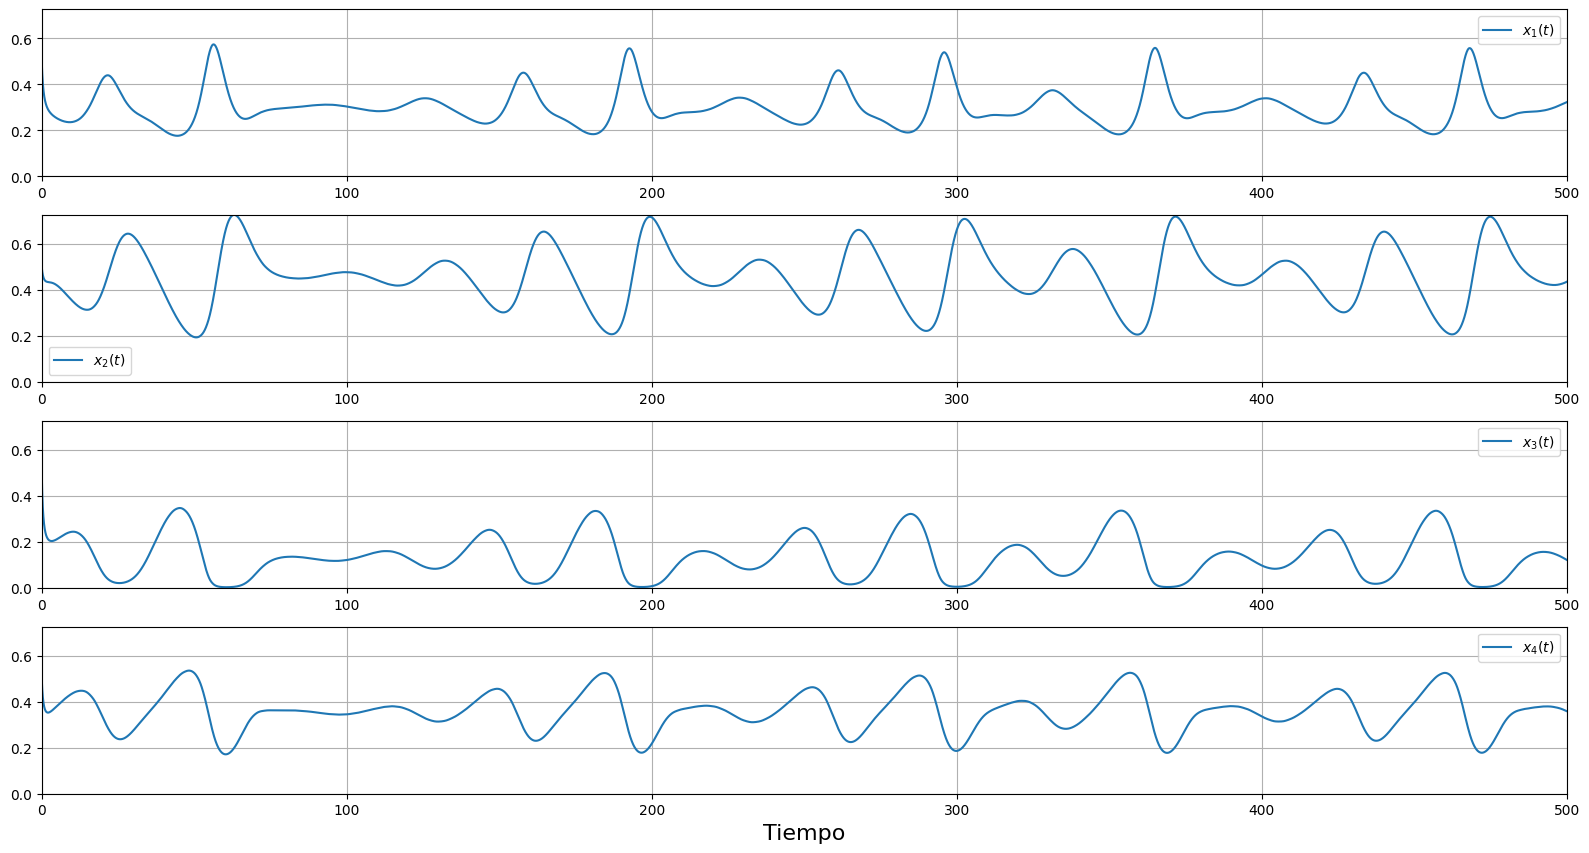

In [4]:
# %matplotlib notebook

# creamos la gráfica
fig, ax = plt.subplots(4, 1, figsize=(16,9))

ax[0].plot(sol.t, sol.y[0], label=f'$x_1(t)$')
ax[1].plot(sol.t, sol.y[1], label=f'$x_2(t)$')
ax[2].plot(sol.t, sol.y[2], label=f'$x_3(t)$')
ax[3].plot(sol.t, sol.y[3], label=f'$x_4(t)$')

# Configuración del tamaño de la fuente de los números en los ejes
plt.rc('xtick', labelsize=13)  
plt.rc('ytick', labelsize=13)

# ajustamos las etiquetas y el título
max_y = sol.y.max()
for i in range(4):
    # ax[i].set_ylabel('Población')
    ax[i].set_xlim(t_span[0], t_span[1])
    ax[i].set_ylim(0, max_y)
    ax[i].legend()
    ax[i].grid(True)

ax[3].set_xlabel('Tiempo', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96]) 

# mostramos la grafica
plt.show()

# la guardamos
# fig.savefig('evol_temp_4especies.png', dpi=600)

In [5]:
# la guardamos
# fig.savefig('evol_temp_4especies.png', dpi=600)

## 1.2. Representación del espacio de fases

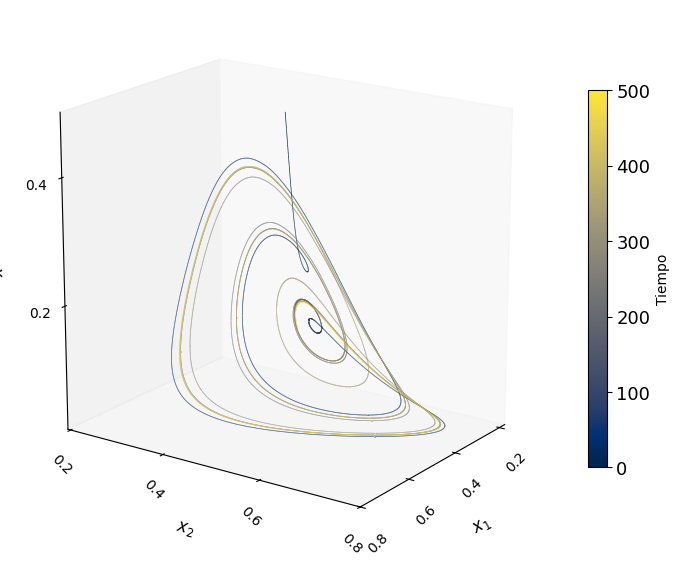

In [6]:
# %matplotlib notebook

# Creamos figura y ejes 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Asignamos color según la evolución temporal
time_sol = sol.t
c = t_span[-1] * (time_sol - time_sol.min()) / (time_sol.max() - time_sol.min())

# Creamos segmentos de línea
points = np.array([sol.y[0], sol.y[1], sol.y[2]]).T.reshape(-1, 1, 3)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Coloreamos los segmentos según 'c'
lc = Line3DCollection(segments, cmap='cividis', norm=plt.Normalize(np.min(c), np.max(c)))
lc.set_array(c)  # Define el gradiente según 'c'
lc.set_linewidth(0.5)  # Define el grosor de la línea
ax.add_collection3d(lc)

# Etiquetas de los ejes y título
ax.set_xlabel(r'$x_1$', fontsize=12, labelpad=10)
ax.set_ylabel(r'$x_2$', fontsize=12, labelpad=10)
ax.set_zlabel(r'$x_3$', fontsize=12, labelpad=10)
# ax.set_title('Espacio de fases', fontsize=14)

# Establecemos límites para que los ejes tengan proporciones iguales
xlim = [np.min(sol.y[0]), np.max(sol.y[0])]
ylim = [np.min(sol.y[1]), np.max(sol.y[1])]
zlim = [np.min(sol.y[2]), np.max(sol.y[2])]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)

# Ajustamos las marcas de los ejes
ax.set_xticks([0.2, 0.4, 0.6, 0.8])
ax.set_yticks([0.2, 0.4, 0.6, 0.8])
ax.set_zticks([0.2, 0.4])

# Ajustes para evitar solapamiento
ax.tick_params(axis='x', labelsize=10, rotation=45)  # Eje X
ax.tick_params(axis='y', labelsize=10, rotation=-45) # Eje Y
ax.tick_params(axis='z', labelsize=10)   

# Quitamos el grid
ax.grid(False)

# Añadimos la barra de color
cbar = plt.colorbar(lc, ax=ax, shrink=0.7)
cbar.set_label('Tiempo')

# Ajustamos proporciones de los ejes
ax.set_box_aspect([np.ptp(xlim), np.ptp(ylim), np.ptp(zlim)])  # Proporciones iguales

# Ajustamos la vista personalizada
ax.view_init(elev=18, azim=35)

# Guardamos la figura (opcional)
# fig.savefig('espacio_fasico_4especies.png', dpi=600)

plt.show()

In [7]:
# fig.savefig('espacio_fasico_4especies.png', dpi=600)

## 1.3. Cálculo de los exponentes de Lyapunov
Para este sistema tenemos el siguiente Jacobiano:
$$
J_{ik}=\frac{\partial \dot x_i}{\partial x_k} = r_i\left[\left( 1-\sum_{j=1}^Na_{ij}x_j \right)\delta_{ik} -x_ia_{ik} \right].
$$

In [8]:
###########    NUEVO

def jacobiano(x, r, a):
    """
    Calcula el jacobiano J(x).
    """
    N = len(r)
    J = np.zeros((N, N))
    Ax = a.dot(x)
    for i in range(N):
        sum_aijxj = Ax[i]
        for k in range(N):
            if i == k:
                J[i, k] = r[i] * ((1 - sum_aijxj) - x[i]*a[i, i])
            else:
                J[i, k] = -r[i]*x[i]*a[i, k]
    return J

def sistema_dinamico(x, r, a, dt):
    N = len(x)
    dxdt = np.zeros(N)
    for i in range(N):
        interaction = np.sum(a[i,:] * x)
        dxdt[i] = r[i] * x[i] * (1 - interaction)
    return x + dxdt * dt


def compute_LCEs(x0, r, a, max_iter):
    # creamos el paso de tiempo
    dt = 500/max_iter  # usamos un tiempo total de 500

    # inicializamos las matrices necesarias
    Q= np. eye(len(x0))
    sum_logs_R = np.zeros(len(x0))
    
    # guardamos para cada iteracion
    LCEs = np.zeros((max_iter, len(x0))) 
    all_logs = LCEs.copy()
    
    for i in range(max_iter):
        # hacemos la descomposicion QR
        J = jacobiano(x0, r, a)
        J_star = J @ Q
        Q, R = np.linalg.qr(J_star)
        
        # nos quedamos con los elementos diagonales
        sum_logs_R += np.log(np.abs(np.diag(R))) 
        all_logs[i] = sum_logs_R
        LCEs[i] = sum_logs_R / (1+i)
        
        # actualizamos el sistema
        sol = solve_ivp(system, [0, dt], x0, args=(r, a), method='RK45')
        x0 = sol.y[:,-1]  
        # x0 = sistema_dinamico(x0, r, a, dt)
        

    return LCEs, all_logs
    

LCEs = compute_LCEs(x0, r, a, 100000)

print("Exponentes de Lyapunov:", LCEs[0])
# print(LCEs[0].shape, LCEs[1].shape)


Exponentes de Lyapunov: [[ 0.84968636 -0.21284282 -0.27133853  0.10641843]
 [ 1.00625036 -0.08767119 -0.32262483 -0.13891761]
 [ 1.04314899  0.00829635 -0.2999758  -0.30924063]
 ...
 [ 0.03032809 -1.04663786 -1.60994249 -1.74155052]
 [ 0.03032788 -1.04664227 -1.60994752 -1.74155289]
 [ 0.03032768 -1.04665014 -1.60994913 -1.74155527]]


Calculamos finalmente los LCEs:


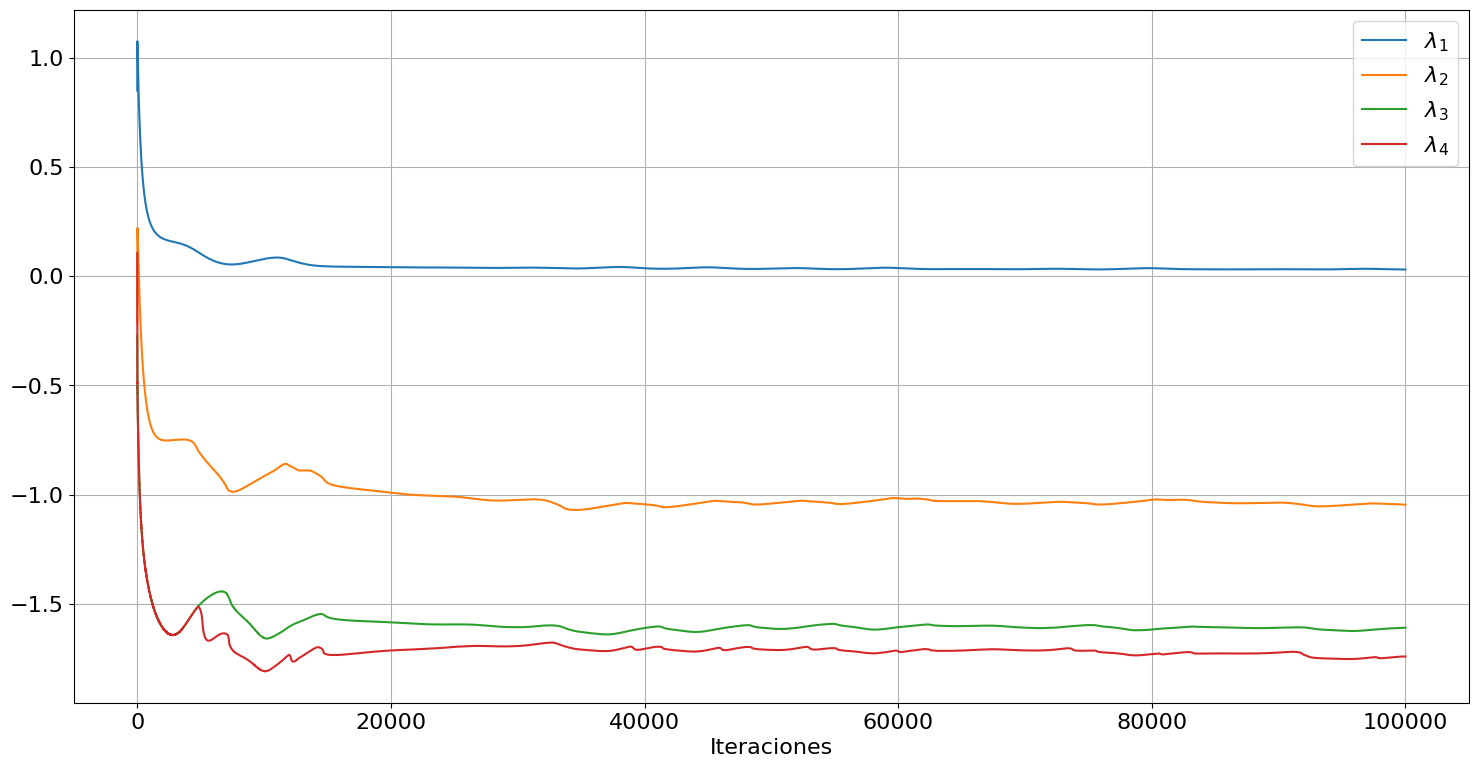

In [9]:
# Crear figura y ejes
fig_lces, ax_lces = plt.subplots(figsize=(18, 9))  

iters = np.arange(0, 100000, 1)
# Graficar los datos
plt.plot(iters, LCEs[0][:, 0], label=r'$\lambda_1$')
plt.plot(iters, LCEs[0][:, 1], label=r'$\lambda_2$')
plt.plot(iters, LCEs[0][:, 2], label=r'$\lambda_3$')
plt.plot(iters, LCEs[0][:, 3], label=r'$\lambda_4$')

# Personalizar los ejes
ax_lces.tick_params(axis='x', labelsize=16)
ax_lces.tick_params(axis='y', labelsize=16)

# Añadir leyenda, guardar y mostrar
plt.legend(fontsize=16)
plt.xlabel(r'Iteraciones', fontsize=16)
plt.grid()
# fig_lces.savefig('LCE_4especies.png', dpi=600)
plt.show()

In [10]:
# fig_lces.savefig('outputs/LCE_4especies.png', dpi=600)

Podemos hallar también su error estándar. Primero, hallamos su desviación típica,

In [11]:
# solo tomamos la mitad final de los valores
n_mitad = len(LCEs[0][:, 0])//2
half_logs = LCEs[0][n_mitad:, :] 

# usamos la función de numpy
est = np.std(half_logs, axis = 0, ddof = 1) ## ddof = 1 porque es una muestra

print('Desviación estándar de los LCEs:', est)

Desviación estándar de los LCEs: [0.00199857 0.00838089 0.00742401 0.01362468]


## 1.4 Cálculo de la matriz de correlación

Necesitamos hallar los pares de coeficientes de correlación de Pearson (r). Para dos series temporales $x_1$, $x_2$, este coeficiente para una muestra es 
$$
r_{ij} = \frac{\text{Cov} (X_i,X_j)}{\sqrt{\text{Var}(X_i)\cdot\text{Var}(X_j)} }  
$$
donde 
$$
\text{Var}(X_i) = \frac{1}{n-1}\sum_{i=1}^n\left( x_i-\bar X \right)^2; \quad \text{Cov}(X, Y) = \frac1{n-1}\sum_{i=1}^n(x_i-\bar X)(y_i-\bar Y) 
$$

In [12]:
# creamos una función para hallar el coeficiente de correlacióne entre dos poblaciones

def ccr(x, y):
    x = np.array(x)
    y = np.array(y)
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    num = np.sum((x - x_mean) * (y - y_mean))
    den = np.sqrt(np.sum((x - x_mean)**2)) * np.sqrt(np.sum((y - y_mean)**2))
    return num / den


In [13]:
# hallamos la matriz de correlación

R_matrix= np.ones((4,4))

for i in range(4):
    for j in range(4):
        R_matrix[i,j] = ccr(sol.y[i], sol.y[j])

print('MATRIZ DE CORRELACIÓN')
print(R_matrix)

MATRIZ DE CORRELACIÓN
[[ 1.          0.11022686 -0.67251669 -0.57760347]
 [ 0.11022686  1.         -0.74976848 -0.86388293]
 [-0.67251669 -0.74976848  1.          0.92200335]
 [-0.57760347 -0.86388293  0.92200335  1.        ]]


## 1.5 Cálculo de la Correlación Total
Para la correlación total, necesitamos conocer la entropía (de información, Shannon) y la entropía conjunta. Se pueden calcular como
$$
H(X) := -\sum p(x)\log p(x);\quad H(X_1, X_2, X_3, X_4) = \sum_{x_1}\sum_{x_2}\sum_{x_3}\sum_{x_4} p(x_1, x_2, x_3, x_4)\log p(x_1, x_2, x_3, x_4).
$$

Con esto, la correlación total se calcula como
$$
TC(X_1, X_2, X_3, X_4) = \left( \sum_{i=1}^n H(X_i)\right) - H (X_1, X_2, X_3, X_4)
$$


In [14]:
# definimos una función para la entropía
## lo hallaremos haciendo histogramas

def entropy(x):
    # usamos la regla de sturges para el numero de bins optimo
    bins = int(np.log(len(x)) + 1)
    print('bins = ',bins)
    
    # hallamos el histograma
    counts, _ = np.histogram(x, bins=bins)
    
    # eliminamos bins vacíos para evitar log(0)
    counts = counts[counts>0]
    
    # normalizamos para que sea la distribución de probabilidad
    p = counts/np.sum(counts)
    
    # hallamos la entropía de shannon
    H = -np.sum(p*np.log(p))
    # plt.plot(x, p) #comentar el filtro para que funcione
    return H

In [15]:
# hallamos la entropía de cada serie
H1 = entropy(sol.y[0])
H2 = entropy(sol.y[1])
H3 = entropy(sol.y[2])
H4 = entropy(sol.y[3])

print(H1, H2, H3, H4)

bins =  12
bins =  12
bins =  12
bins =  12
2.088557442556071 2.3497427904834494 2.002294713178705 2.291063668727667


In [16]:
# para la entropía conjunta podemos hallar el histograma conjunto
def joint_entropy(x1, x2, x3, x4):
    bins = int(np.log(len(x1)) + 1)
    
    # creamos un solo array
    data = np.hstack((x1, x2, x3, x4))
    
    # hallamos el histograma multidimensional
    hist, _ = np.histogramdd(data, bins=bins)
    
    # aplanar y eliminar bins con 0s
    hist = hist.flatten() # para que sea un solo vector
    hist_nonzero = hist[hist>0]
    
    # hallamos la distribución de probabilidad
    p = hist_nonzero/np.sum(hist_nonzero)
    
    # hallamos entropía conjunta
    H = -np.sum(p*np.log(p))
    return H

In [17]:
# la calculamos
H_joint = joint_entropy(sol.y[0], sol.y[1], sol.y[2], sol.y[3])
print(H_joint)

2.2856967308008893


In [18]:
# hallamos la correlación total
TC = np.sum([H1, H2, H3, H4]) - H_joint

print('TC = ',TC)

TC =  6.445961884145001


En esencia, aunque cada población por separado tiene una cierta incertidumbre (o variabilidad), al combinarlas, se reduce drásticamente la incertidumbre total. Esto indica que las poblaciones no actúan de manera independiente, sino que comparten una gran parte de la información. En otras palabras, el estado o comportamiento de una población refleja en gran medida el de las otras, lo cual puede sugerir la presencia de factores comunes o interacciones fuertes entre ellas.

Esta fuerte dependencia implica que, a efectos de análisis o modelado, podría no ser necesario considerar cada población de forma aislada, ya que muchas de sus variaciones son redundantes.

## 1.6 Estudio de la correlación temporal
Lo dejo para más adelante       

## 1.7 Tiempo medio de extinción
Para el caso determinista creo que es trivial, pero haré pruebas con tiempos largos.

In [19]:
def tiempo_ext(x, t, umbral = 1e-9):
    ind = np.where(x < umbral)[0]
    
    # puede que no se extingan
    if len(ind) == 0:
        return None
    
    idx = ind[0]
    
    # podemos interpolar entre los dos puntos
    t0, t1 = t[idx-1], t[idx]
    x0, x1 = x[idx-1], x[idx]
    t_ext = t0 + (umbral - x0)*(t1-t0)/(x1-x0)
    return t_ext

In [20]:
sol2 = solve_ivp(system, (0, 500000), x0, args=(r,a), t_eval = t_eval)

ext_1 = tiempo_ext(sol2.y[0], sol2.t)
ext_2 = tiempo_ext(sol2.y[1], sol2.t)
ext_3 = tiempo_ext(sol2.y[2], sol2.t)
ext_4 = tiempo_ext(sol2.y[3], sol2.t)

print(ext_1, ext_2, ext_3, ext_4)

None None None None


Para un tiempo de 500k, obtenemos siempre NO-EXTINCIÓN.

## 1.8 Distribución estacionaria

## 1.9 Varianza y Coeficiente de varianza


---
# 2. Modelo estocástico

Aplicamos el método de Euler-Maruyama para resolver la ecuación de Languevin. Tras la discretización de $\Delta t = T/N$, obtenemos
$$
x_i^{(n+1)} = x_i^{(n)}+r_ix_i^{(n)}\left( 1-\sum_{j=1}^Na_{ij}x_j^{(n)} \right)\Delta t + \sigma_i x_i^{(n)}\sqrt{\Delta t}\zeta_i^{(n)}.
$$

In [21]:
def euler_maruyama(model, x0, t_span, dt, r, a, sigma):
    """
    Euler maruyama method
    :param system:  función definida antes
    :param x0: condición inicial (array de len N)
    :param t0: tiempo inicial (float)
    :param t_max: tiempo final (float)
    :param dt: step del tiempo (float)
    :param r: array con r_i
    :param a: matriz con a_ij
    :param sigma: array con sigma_i
    :return: (t_vals, x_vals), con x_vals un array (num_steps+1, N)
    """
    
    np.random.seed(2) 
    N=len(x0) # en nuestro caso será 4
    t0 = t_span[0]
    t_max = t_span[-1]
    num_steps = int((t_max-t0)/dt)
    
    # guardamos los valores 
    t_vals = np.linspace(t0, t_max, num_steps+1)
    x_vals = np.zeros((num_steps+1,N))
    
    x_vals[0, :] = x0
    x = x0.copy()
    
    for n in range(num_steps): # para cada paso temporal
        t = t_vals[n]
        
        # parte determinista
        F = model(t,x,r,a) # también array de 4

        # vector del ruido
        for i in range(N): # para cada especie
            # introducimos la variable aletoria
            zetta = np.random.normal(0, 1)
            
            # hallamos el siguiente valor
            x[i] = x[i]+ F[i]*dt + sigma[i]*x[i]*np.sqrt(dt)*zetta
            
            # si baja del umbral, suponemos que se extingue
            if x[i] <= 1e-9:
                x[i] = 0
                
            x_vals[n+1,i] = x[i]    
    return t_vals, x_vals
    


## 2.1. Evolución temporal
Ahora lo aplicamos,

In [59]:
# tomamos los parámetros de antes
N=4
r = np.array(
    [1, 0.72, 1.53, 1.27]
)

a = np.array([
    [1, 1.09, 1.52, 0],
    [0, 1, 0.44, 1.36],
    [2.33, 0, 1, 0.47],
    [1.21, 0.51, 0.35, 1]
])

x0 = np.array([0.5, 0.5, 0.5, 0.5])
t_span = (0, 500)

# escogemos un paso de tiempo pequeño 
# pero a la vez mantenemos el numero de puntos en 10^5
dt = t_span[-1]/(1e6)
print('paso temporal: ', dt)

# definimos una intesidad para el ruido
sigma = np.array([0,0,0,0])                                                                           ##### RUIDO 0
# sigma = np.array([0.075, 0.075, 0.075, 0.075]) # sin extinciones                                      ##### RUIDO 1
# sigma = np.array([.5, .2, .05, .2]) # aumenta autocorrelacion; se extinguen dos                       ##### RUIDO 2
# sigma = np.array([.01, .01, 1, 0.01]) # aumenta mucho la autocorrelación; se extingue uno             ##### RUIDO 3

# aplicamos EM
t_vals_EM_4esp, x_vals_EM_4esp = euler_maruyama(system, x0, t_span, dt, r, a, sigma)
print('tiempo = ', t_vals_EM_4esp)
print('valores de x = ',x_vals_EM_4esp)

paso temporal:  0.0005
tiempo =  [0.000000e+00 5.000000e-04 1.000000e-03 ... 4.999990e+02 4.999995e+02
 5.000000e+02]
valores de x =  [[0.5        0.5        0.5        0.5       ]
 [0.49979875 0.499928   0.49965575 0.49983014]
 [0.49959778 0.49985609 0.49931208 0.49966051]
 ...
 [0.26341082 0.48515218 0.15509492 0.35784631]
 [0.26340713 0.48514518 0.15510239 0.35785125]
 [0.26340345 0.48513818 0.15510986 0.35785618]]


In [60]:
print('min en x_2', np.min(x_vals_EM_4esp[:,1]))

min en x_2 0.17848102010036795


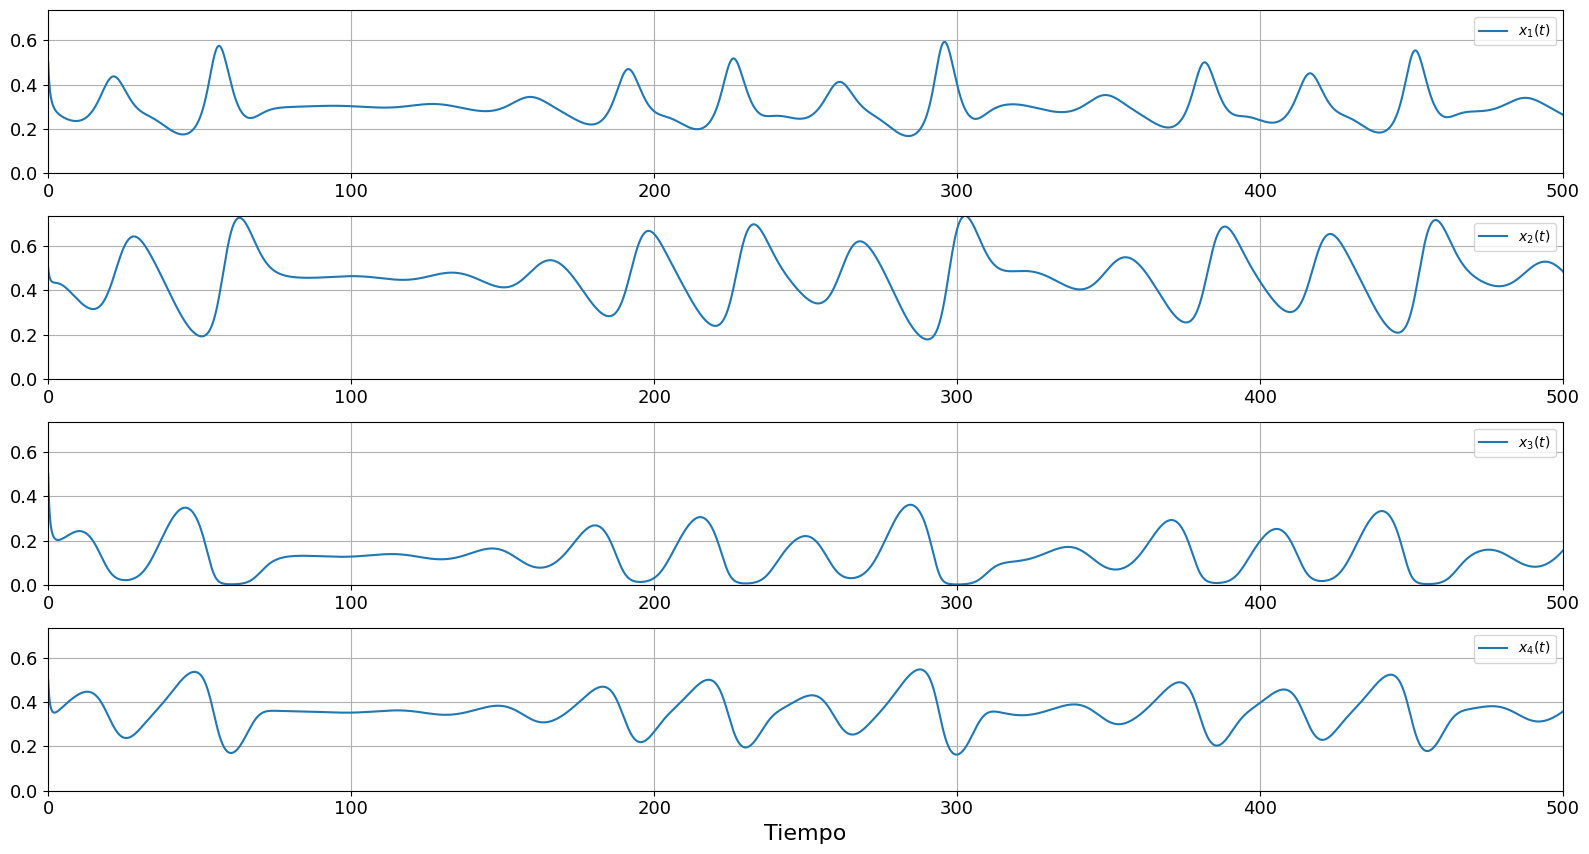

In [61]:
 # %matplotlib notebook

# creamos la gráfica
fig_em, ax_em = plt.subplots(4, 1, figsize=(16,9))

ax_em[0].plot(t_vals_EM_4esp, x_vals_EM_4esp[:,0], label=f'$x_1(t)$')
ax_em[1].plot(t_vals_EM_4esp, x_vals_EM_4esp[:,1], label=f'$x_2(t)$')
ax_em[2].plot(t_vals_EM_4esp, x_vals_EM_4esp[:,2], label=f'$x_3(t)$')
ax_em[3].plot(t_vals_EM_4esp, x_vals_EM_4esp[:,3], label=f'$x_4(t)$')

# ajustamos las etiquetas y el título
max_y = x_vals_EM_4esp.max()
for i in range(4):
    ax_em[i].set_ylim([0, max_y])
    ax_em[i].set_xlim([t_span[0], t_span[1]])
    ax_em[i].legend()
    ax_em[i].grid(True)

ax_em[3].set_xlabel('Tiempo', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96]) 


# mostramos la gráfica
plt.show()

# fig_em.savefig('outputs/ruido1/evol_temp_4especies_ruido1.png', dpi=600)


In [62]:
# fig_em.savefig('outputs/ruido1/evol_temp_4especies_ruido1.png', dpi=600)

## 2.2. Representación del espacio de fases
También podemos hallar su espacio de fases como hicimos cuando estábamos en el caso determinista:

Forma de lineas: (1000000, 2, 3)
Forma de col: (1000001,)


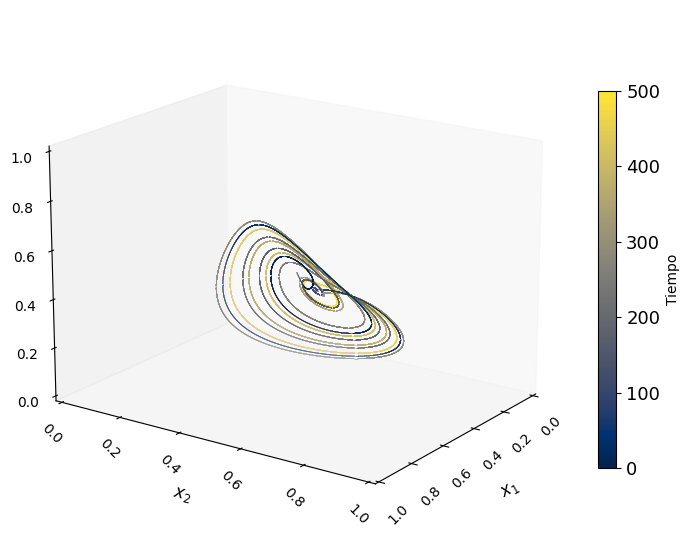

In [63]:
 # %matplotlib notebook


fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

# asignamos el color segun el tiempo
time_val = t_vals_EM_4esp[:]
col = t_span[1] * (time_val - time_val.min()) / (time_val.max() - time_val.min())

# creamos las lineas
puntos = np.array([x_vals_EM_4esp[:,0], x_vals_EM_4esp[:,1], x_vals_EM_4esp[:,3]]).T.reshape(-1, 1, 3)
lineas = np.concatenate([puntos[:-1], puntos[1:]], axis=1)
print("Forma de lineas:", lineas.shape)  # Debe ser (n_lines, 2, 3)
print("Forma de col:", col.shape)  


# coloreamos según col 
LC = Line3DCollection(lineas, cmap='cividis', norm = plt.Normalize(np.min(col), np.max(col)))
LC.set_array(col)
LC.set_linewidth(0.5)
ax.add_collection3d(LC)

# etiquetamos ejes y titulos
ax.set_xlabel(r'$x_1$', fontsize=12, labelpad=10)
ax.set_ylabel(r'$x_2$', fontsize=12, labelpad=10)
ax.set_zlabel(r'$x_3$', fontsize=12, labelpad=10)

# ponemos los ejes
xlim = [np.min(x_vals_EM_4esp[:,0]), np.max(x_vals_EM_4esp[:,0])]
ylim = [np.min(x_vals_EM_4esp[:,1]), np.max(x_vals_EM_4esp[:,1])]
zlim = [np.min(x_vals_EM_4esp[:,3]), np.max(x_vals_EM_4esp[:,3])]
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)
# ax.set_zlim(zlim)

# ax.set_xticks([0.2, 0.4, 0.6, 0.8])
# ax.set_yticks([0.2, 0.4, 0.6, 0.8])
# ax.set_zticks([0.2, 0.4])

ax.tick_params(axis='x', labelsize=10, rotation=45)  
ax.tick_params(axis='y', labelsize=10, rotation=-45) 
ax.tick_params(axis='z', labelsize=10)  


# Quitamos el grid
ax.grid(False)

# Añadimos la barra de color
cbar = plt.colorbar(LC, ax=ax, shrink=0.7)
cbar.set_label('Tiempo')

# Ajustamos proporciones de los ejes
ax.set_box_aspect([np.ptp(xlim), np.ptp(ylim), np.ptp(zlim)])  # Proporciones iguales

# Ajustamos la vista personalizada
ax.view_init(elev=18, azim=35)

plt.show()

# Guardamos la figura (opcional)
# fig.savefig('outputs/espacio_fasico_4especies_ruido1.png', dpi=600)




## 2.3. Cálculo de los exponentes de Lyapunov

Necesitamos un procedimiento diferente al aplicado en el caso determinista. Nos basamos en la aproximación usada en el paper de Wolf et al., donde se haya el mayor LCE reconstruyendo el atractor de una serie temporal.

In [64]:

def nearest_neighbour_4D(data_4d, idx, min_separation = 50):
    '''
    Busca el punto más cercano para el punto data_4d[idx],
    excluyendo los puntos que están muy próximos en el tiempo.
    
    :param data_4d: ndarray, shape (N,4)
    :param idx: int
        Índice del punto de referencia
    :param min_separation: int
        Número mínimo de índices (pasos de tiempo) para evitar vecinos de la misma órbita
    :return: nn_idx: int
        Índice del vecino más cercano
    :return dist_min: float
        Distancia mínima encontrada
    '''
    
    ref_point = data_4d[idx]
    
    # hallamos todas las distancias 
    dists = np.linalg.norm(data_4d - ref_point, axis = 1)
    # excluimos el propio punto
    dists[idx] = np.inf
    
    # excluimos puntos en un rango temporal muy cercano
    start_excl = max(0, idx - min_separation)
    end_excl = min(len(data_4d), idx + min_separation)
    dists[start_excl:end_excl] = np.inf
    
    nn_idx = np.argmin(dists)
    dist_min = dists[nn_idx]
    return nn_idx, dist_min


In [65]:
def estimate_LCE1_Wolf(data_4d, evol_time, min_separation, dt, max_replacements, start_indices):
    '''
    
    Estimamos el mayor exponentes de Lyapunov usando el método 
    de Wolf  (en fixed time) para datos en R^4
    
    :param data_4d: ndarray, shape (N,4)
        Cada fila es un vector (x1, x2, x3, x4) en el instante de muestreo
    :param evol_time: int
        Número de pasos que se deja evolucionar cada par antes de renormalizar
    :param min_separation: int
        Número mínimo de pasos para excluir puntos muy próximos temporalmente
    :param df: float 
        Intervalo de muestreo
    :param max_replacements: int
        Número máximo de renormalizaciones a realizar
    :param start_indices: list
        Lista de índices iniciales a usar como puntos de referencia para promediar la estimación
        
    :return: lambda1: float
        Estimación del mayor LCE 
        
    :return: lambda_estimates: array
        Vector con la estimación de lamba1 en cada punto inicial
    '''
    
    N = len(data_4d)
        
    # almacenamos la estimación de cada punto
    lambda_estimates = [] 
    
    for init_idx in start_indices:
        idx_f = init_idx
        log_sum = 0.0
        count = 0
        
        # iteramos mientras se pueda evolucionar el punto de referencia y sin superar el máximo de iteraciones
        while (idx_f + evol_time < N) and (count < max_replacements):
            # buscamos vecino más cercano para el de referencia más cercano
            idx_n, dist_init = nearest_neighbour_4D(data_4d, idx_f, min_separation)
            
            # vemos que la distancia inicial es valida
            if np.isinf(dist_init) or dist_init < 1e-12:
                break
                
            # definimos los índices después de la evolución
            idx_f_next = idx_f + evol_time
            idx_n_next = idx_n + evol_time
            
            if idx_f_next >= N or idx_n_next >= N:
                break
            
            # calculamos la separación final
            dist_final = np.linalg.norm(data_4d[idx_f_next] - data_4d[idx_n_next])
            
            # acumulamos el logaritmo del crecimiento
            log_sum += np.log(dist_final / dist_init)
            count += 1
            
            # renormalizamos
            idx_f = idx_f_next
        
        if count > 0:
            lambda_local = (log_sum / (count * evol_time * dt))
            
        else:
            lambda_local =np.nan
        
        # guardamos el valor a la lista       
        lambda_estimates.append(lambda_local)

    if len(lambda_estimates) > 0:
        # hacemos la media (quitando los nans)
        lambda1 = np.nanmean(lambda_estimates)

    else:
        lambda1 = 0
    
    return lambda1, lambda_estimates

Voy a hallar el tiempo de decorrelación para usarlo como referencia en el evol_time

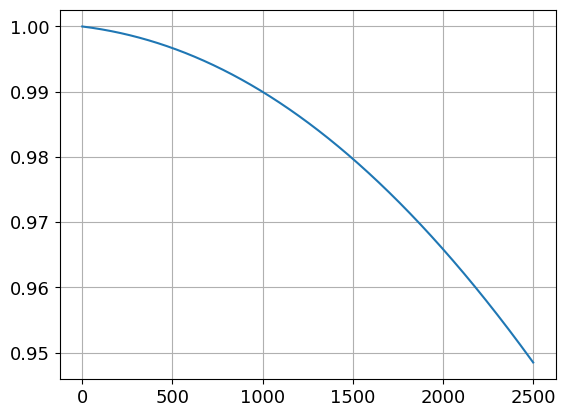

In [66]:
from statsmodels.tsa.stattools import acf

x1 = x_vals_EM_4esp[:,0]
x2 = x_vals_EM_4esp[:,1]
x3 = x_vals_EM_4esp[:,2]
x4 = x_vals_EM_4esp[:,3]
data_4d = np.array([x1, x2, x3, x4]).T

autocorr = acf(data_4d[:,0],nlags=2500)
plt.plot(autocorr)
plt.grid(True)
plt.show()

Debe ser superior al valor en el que corta con el eje horizontal. Tomaremos evol_time = 1500

In [67]:
# lo aplicamos a nuestro sistema de 4 especies
t = t_vals_EM_4esp  
dt = t[1] - t[0]
print('dt =', dt)

# definimos nuestro array de datos en R^4
x1 = x_vals_EM_4esp[:,0]
x2 = x_vals_EM_4esp[:,1]
x3 = x_vals_EM_4esp[:,2]
x4 = x_vals_EM_4esp[:,3]

data_4d = np.array([x1, x2, x3, x4]).T

# Parámetros para el algoritmo
evol_time = 5000         # número de pasos para evolución entre renormalizaciones
min_sep = 1800            # separación mínima en el tiempo para evitar vecinos triviales
max_rep = 5000       # máximo número de renormalizaciones

# Podemos usar varios puntos de inicio para mejorar la estadística
start_indices = list(range(0, (len(data_4d)-evol_time), 100))

# tomo los valores intermedios
in_i = int(len(data_4d)/5)
in_f = int(len(data_4d) * 4/5)
start_indices = list(range(in_i, in_f, 100))


# estimamos lambda1
lambda1, lambda_array = estimate_LCE1_Wolf(data_4d, evol_time=evol_time, 
                                min_separation=min_sep, dt=dt,  
                                max_replacements=max_rep, start_indices=start_indices)

print(f"Estimación del mayor exponente de Lyapunov: λ₁ ≈ {lambda1:.5f} [1/segundo]")
print('len(lambda_array):', len(lambda_array))

dt = 0.0005
Estimación del mayor exponente de Lyapunov: λ₁ ≈ 0.07715 [1/segundo]
len(lambda_array): 6000


In [68]:
# hallamos su desviación estandar
error_std = np.nanstd(lambda_array, ddof=1) 
media_lambda = np.nanmean(lambda_array)
print('Desviación estándar:', error_std)
print('Valor promedio:', media_lambda)

Desviación estándar: 0.019247642603708162
Valor promedio: 0.07714819331665596


<>:10: SyntaxWarning: invalid escape sequence '\h'
<>:27: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\h'
<>:27: SyntaxWarning: invalid escape sequence '\s'
C:\Users\kikek\AppData\Local\Temp\ipykernel_55704\3500276459.py:10: SyntaxWarning: invalid escape sequence '\h'
  plt.plot(start_indices, vect_media, 'r--', alpha = 0.9, label = f'Media $\hat\lambda_1 = $ {media_lambda:.3f}')
C:\Users\kikek\AppData\Local\Temp\ipykernel_55704\3500276459.py:27: SyntaxWarning: invalid escape sequence '\s'
  label=f'Desv. Est. $\sigma_\lambda = $ {error_std:.2f}'


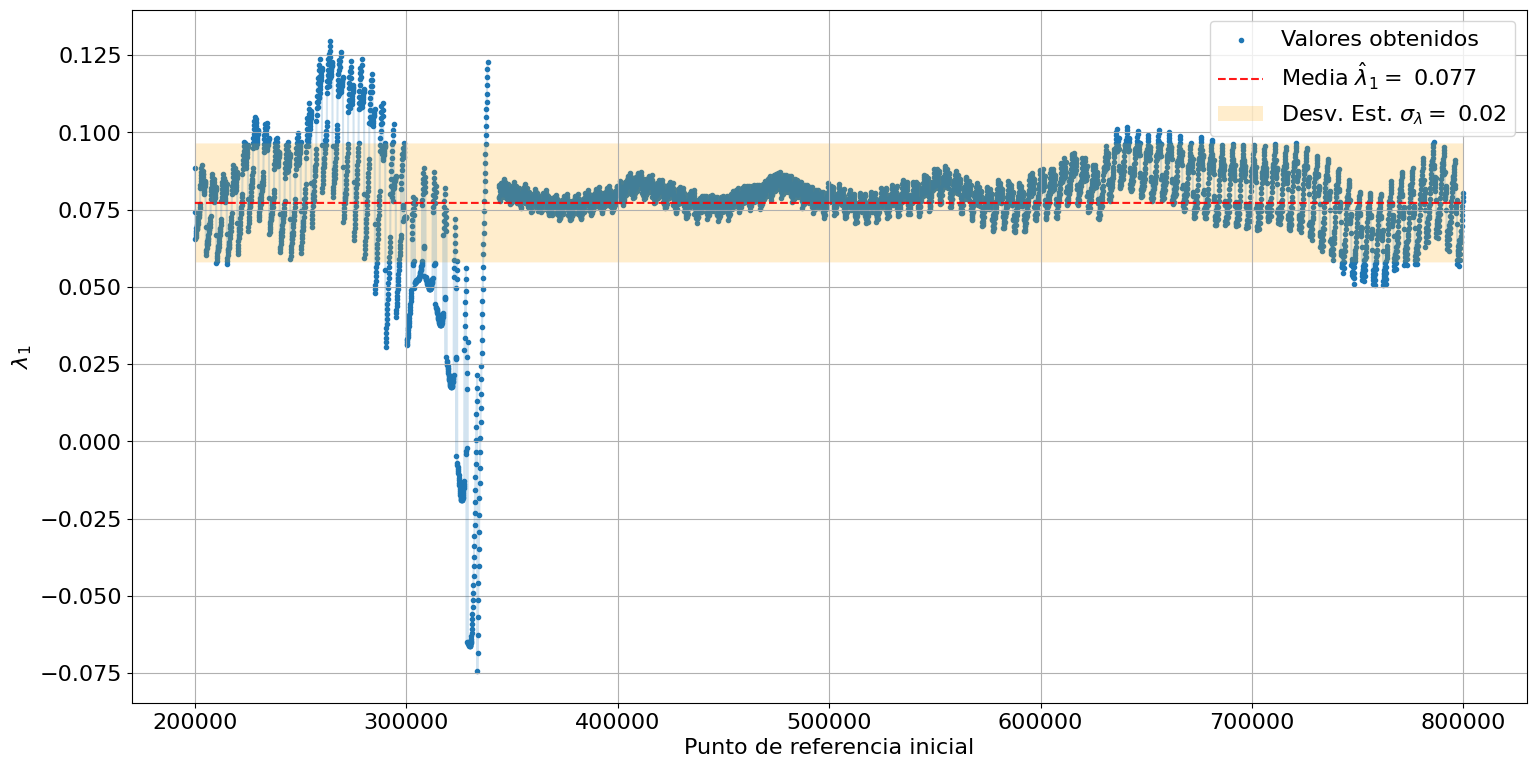

In [69]:
# vemos su convergencia
fig_wolf_det, ax_wolf = plt.subplots(figsize = (18,9))

# graficamos los datos
plt.plot(start_indices, lambda_array, alpha = 0.2) 
plt.scatter(start_indices, lambda_array, linewidths=1, marker = ".", label = 'Valores obtenidos')

# linea media
vect_media = media_lambda * np.ones_like(start_indices)
plt.plot(start_indices, vect_media, 'r--', alpha = 0.9, label = f'Media $\hat\lambda_1 = $ {media_lambda:.3f}')
plt.xlabel("Punto de referencia")

# ponemos la banda de la desviación estándar
vect_media = media_lambda * np.ones_like(start_indices)

## límites superior e inferior 
y_min = vect_media - error_std
y_max = vect_media + error_std

## dibujamos la banda
plt.fill_between(
    start_indices, 
    y_min, 
    y_max, 
    alpha=0.2,         # Ajusta la opacidad 
    facecolor='orange',    # Elige el color que prefieras
    label=f'Desv. Est. $\sigma_\lambda = $ {error_std:.2f}'
)

# cambiamos los ejes un poco
ax_wolf.tick_params(axis='x', labelsize=16)
ax_wolf.tick_params(axis='y', labelsize=16)
plt.xlabel('Punto de referencia inicial', fontsize=16)
plt.ylabel(r'$\lambda_1$', fontsize=16)
plt.legend(loc='best', fontsize=16)
plt.grid()
# plt.tight_layout()
plt.show()

In [70]:
# fig_wolf_det.savefig('outputs/ruido1/wolf_lces.png', dpi=600)


## 2.4 Cálculo de la matriz de correlación
Podemos usar la función definida para el caso determinista

In [71]:
R_matrix_est= np.ones((4,4))

for i in range(4):
    for j in range(4):
        R_matrix_est[i,j] = ccr(x_vals_EM_4esp[:,i], x_vals_EM_4esp[:,j])

print('MATRIZ DE CORRELACIÓN')
print(R_matrix_est)

MATRIZ DE CORRELACIÓN
[[ 1.          0.11082462 -0.67220236 -0.57768178]
 [ 0.11082462  1.         -0.74980627 -0.8638121 ]
 [-0.67220236 -0.74980627  1.          0.92165086]
 [-0.57768178 -0.8638121   0.92165086  1.        ]]


## 2.5 Cálculo de la Correlación Total
Aplicamos las funciones que hemos definido antes

In [72]:
# hallamos la entropía de cada serie
H1_est = entropy(x_vals_EM_4esp[:,0])
H2_est = entropy(x_vals_EM_4esp[:,1])
H3_est = entropy(x_vals_EM_4esp[:,2])
H4_est = entropy(x_vals_EM_4esp[:,3])

print(H1_est , H2_est , H3_est , H4_est )

bins =  14
bins =  14
bins =  14
bins =  14
2.161747638540881 2.45482001365699 2.130977767037823 2.3856209701544415


In [73]:
# la calculamos
H_joint_est = joint_entropy(x_vals_EM_4esp[:,0] , x_vals_EM_4esp[:,1] , x_vals_EM_4esp[:,2] , x_vals_EM_4esp[:,3] )
print(H_joint_est)

2.414590105444649


In [74]:
# hallamos la correlación total
TC_est = np.sum([H1_est, H2_est, H3_est, H4_est]) - H_joint_est

print('TC = ',TC_est)

TC =  6.718576283945486


---
# 3. Comparaciones

## 3.1 Comparación de la evolución temporal
Voy a ver la diferencia de la resolución de nuestro sistema mediante solve_ivp() y el método de Euler-Maruyama

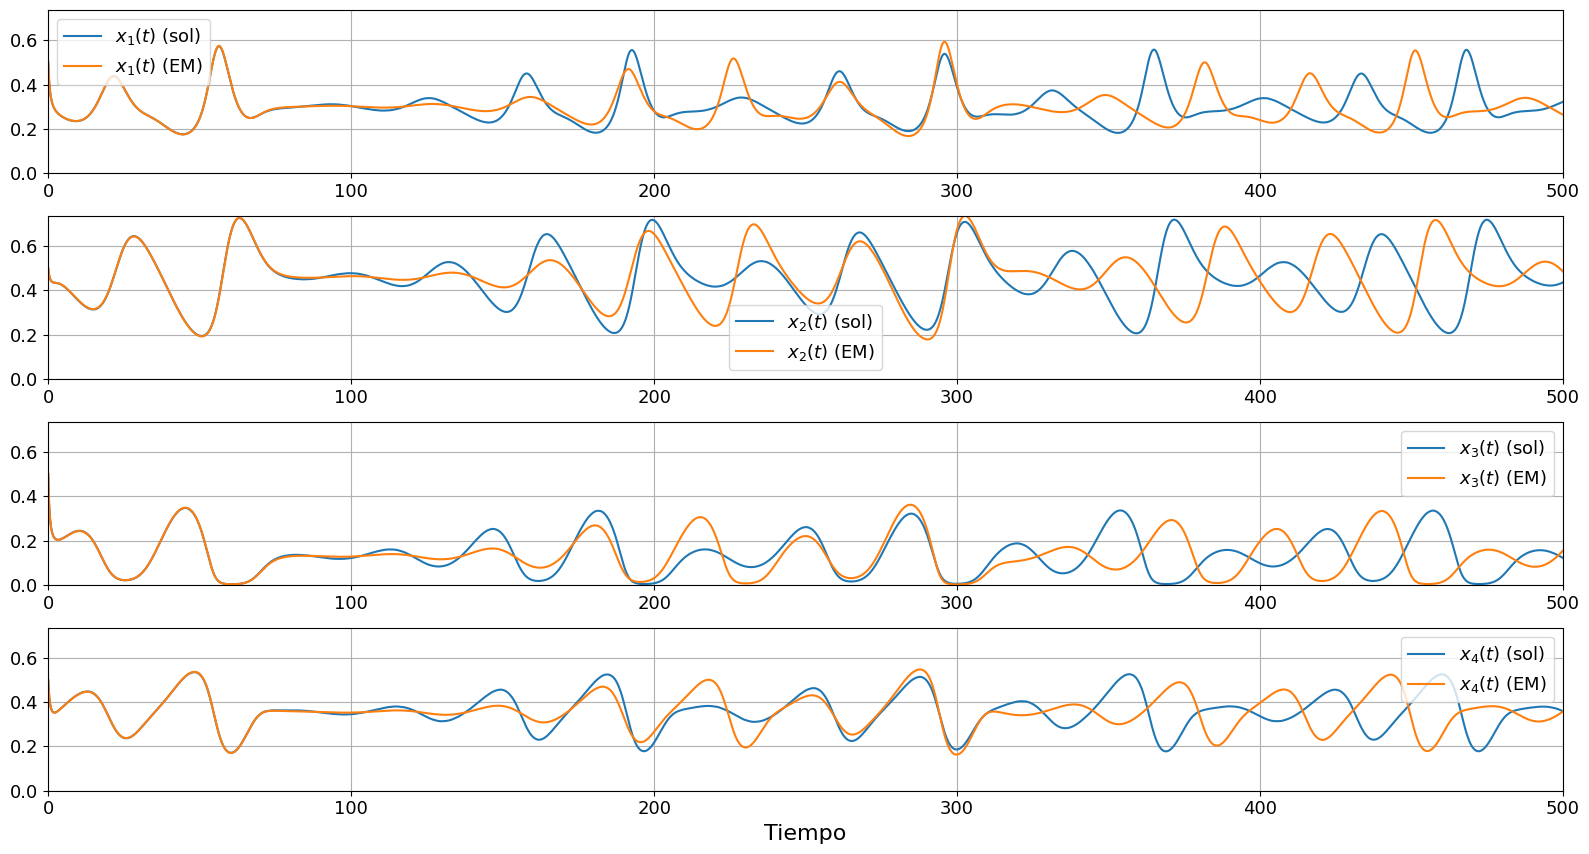

In [75]:
fig, ax = plt.subplots(4, 1, figsize=(16, 9))

# Graficamos la solución "sol"
ax[0].plot(sol.t, sol.y[0], label='$x_1(t)$ (sol)')
ax[1].plot(sol.t, sol.y[1], label='$x_2(t)$ (sol)')
ax[2].plot(sol.t, sol.y[2], label='$x_3(t)$ (sol)')
ax[3].plot(sol.t, sol.y[3], label='$x_4(t)$ (sol)')

# Graficamos la solución "EM"
ax[0].plot(t_vals_EM_4esp, x_vals_EM_4esp[:, 0], label='$x_1(t)$ (EM)')
ax[1].plot(t_vals_EM_4esp, x_vals_EM_4esp[:, 1], label='$x_2(t)$ (EM)')
ax[2].plot(t_vals_EM_4esp, x_vals_EM_4esp[:, 2], label='$x_3(t)$ (EM)')
ax[3].plot(t_vals_EM_4esp, x_vals_EM_4esp[:, 3], label='$x_4(t)$ (EM)')

# Ajustes generales para cada subplot
max_y = max(sol.y.max(), x_vals_EM_4esp.max())
for i in range(4):
    ax[i].set_xlim(t_span[0], t_span[1])
    ax[i].set_ylim(0, max_y)
    ax[i].grid(True)
    ax[i].legend(fontsize=13)  # Aseguramos que la leyenda distinga ambas series

ax[3].set_xlabel('Tiempo', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

<>:24: SyntaxWarning: invalid escape sequence '\_'
<>:24: SyntaxWarning: invalid escape sequence '\_'
C:\Users\kikek\AppData\Local\Temp\ipykernel_55704\279426649.py:24: SyntaxWarning: invalid escape sequence '\_'
  line_solv = mlines.Line2D([], [], color='C0', label=f'Valores de $solve\_ivp()$')


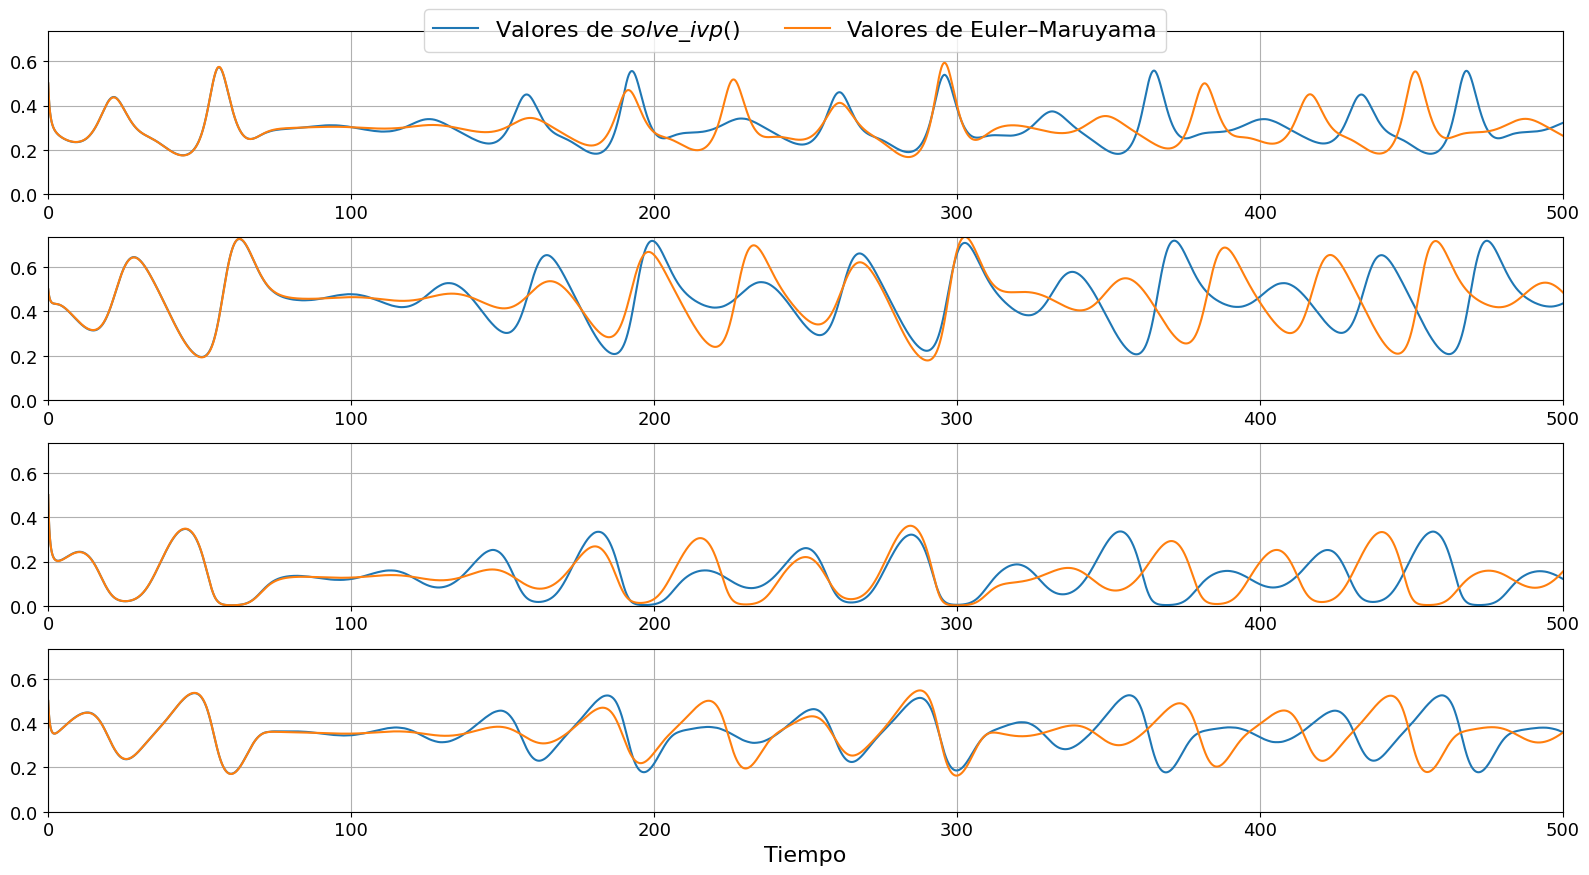

In [83]:
import matplotlib.lines as mlines
fig, ax = plt.subplots(4, 1, figsize=(16, 9))

# Graficamos la solución "sol" (solve_ivp)
ax[0].plot(sol.t, sol.y[0])
ax[1].plot(sol.t, sol.y[1])
ax[2].plot(sol.t, sol.y[2])
ax[3].plot(sol.t, sol.y[3])

# Graficamos la solución "EM" (Euler–Maruyama)
ax[0].plot(t_vals_EM_4esp, x_vals_EM_4esp[:, 0])
ax[1].plot(t_vals_EM_4esp, x_vals_EM_4esp[:, 1])
ax[2].plot(t_vals_EM_4esp, x_vals_EM_4esp[:, 2])
ax[3].plot(t_vals_EM_4esp, x_vals_EM_4esp[:, 3])

# Ajustes generales para cada subplot
max_y = max(sol.y.max(), x_vals_EM_4esp.max())
for i in range(4):
    ax[i].set_xlim(t_span[0], t_span[1])
    ax[i].set_ylim(0, max_y)
    ax[i].grid(True)

# Creamos dos "dummy" lines para la leyenda global.
line_solv = mlines.Line2D([], [], color='C0', label=f'Valores de $solve\_ivp()$')
line_em = mlines.Line2D([], [], color='C1', label='Valores de Euler–Maruyama')

# Agregamos la leyenda global en la parte superior central de la figura.
fig.legend(handles=[line_solv, line_em],
           loc='upper center',
           bbox_to_anchor=(0.5, 0.98),
           ncol=2,
           fontsize=16)

ax[3].set_xlabel('Tiempo', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [84]:
# fig.savefig('outputs/comp_trayectorias.png', dpi=600)